In [1]:
import itertools
import gc
import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns
import xgboost as xgb
import random
from IPython.display import HTML

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# pull in property data

props = pd.read_csv('zillow/properties_2016.csv')
train = pd.read_csv('zillow/train_2016_v2.csv')
sample = pd.read_csv('zillow/sample_submission.csv')

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# check if there are multiple transactions in a month

merged = train.merge(props, how='left', on='parcelid')
merged = df_train = split_date(merged, 'transactiondate')
merged.loc[merged.duplicated(['parcelid', 'transactiondate_year', 'transactiondate_month'], keep=False)]

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,transactiondate_year,transactiondate_month,transactiondate_week,transactiondate_day,transactiondate_dayofweek
45628,12584665,0.2829,2016-06-15,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,582757.0,7087.04,NaN,NaN,NaN,2016,6,24,15,2
45629,12584665,0.0478,2016-06-22,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,582757.0,7087.04,NaN,NaN,NaN,2016,6,25,22,2
80673,14367791,2.0550,2016-09-29,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,1818485.0,43143.70,NaN,NaN,NaN,2016,9,39,29,3
80674,14367791,2.1240,2016-09-30,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,1818485.0,43143.70,NaN,NaN,NaN,2016,9,39,30,4


In [19]:
# check if all the properties are represented in the required submission

diff = set(props['parcelid']) - set(sample['ParcelId'])
display(len(diff) == 0)

True

In [35]:
def xgb_train(X, y):
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=False)

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)

    del x_train, x_valid; gc.collect()

    params = {
        'eta': 0.02,
        'objective': 'reg:linear',
        'eval_metric': 'mae',
#         'max_depth': 3
        'silent': 1,        
        'gamma': 2,
        'alpha': 2,
    }

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)
    
    del d_train, d_valid; gc.collect()
    
    return clf

def xgb_predict(xgb, props, train_columns):
    
    # build the test set
    x = pd.DataFrame()
    for year, month in itertools.product(range(2016, 2018), range(10, 13)):
        part = pd.DataFrame()
        part['parcelid'] = sample['ParcelId']
        part['transactiondate_year'] = year
        part['transactiondate_month'] = month
        x  = x.append(part)
    
    x['logerror'] = 0
    display(x)
    x = x.pivot_table(index='parcelid', columns=['transactiondate_year', 'transactiondate_month'], values='logerror')
    display(x)
#     x = x.merge(props, on='parcelid', how='left')
    
#     x_test = df_test[train_columns]
#     for c in x_test.dtypes[x_test.dtypes == object].index.values:
#         x_test[c] = (x_test[c] == True)

#     del df_test; gc.collect()

#     d_test = xgb.DMatrix(x)
#     del x; gc.collect()

#     x['logerror'] = clf.predict(d_test)
#     del d_test; gc.collect()

#     sub = pd.read_csv('zillow/sample_submission.csv')
#     for c in sub.columns[sub.columns != 'ParcelId']:
#         sub[c] = p_test

#     print('Writing csv ...')
#     sub.to_csv('zillow/xgb_starter.csv', index=False, float_format='%.4f') # Thanks to @inversion

xgb_predict(0, 0, 0)

# utility function for splitting the date into components
def split_date(df, datecol):
    df[datecol] = pd.to_datetime(df[datecol])
    df[datecol+'_year'] = df[datecol].dt.year
    df[datecol+'_month'] = df[datecol].dt.month
#     df[datecol+'_week'] = df[datecol].dt.week
#     df[datecol+'_day'] = df[datecol].dt.day
#     df[datecol+'_dayofweek'] = df[datecol].dt.dayofweek
    return df

def add_age(df):
    df['age'] = (df['transactiondate_year'] - df['yearbuilt']) * 12 + df['transactiondate_month']
    return df

# train a model
def do_train(train, props):
    df_train = train.merge(props, how='left', on='parcelid')
    df_train = split_date(df_train, 'transactiondate')
    df_train = add_age(df_train)
    
    X = df_train.drop(['parcelid', 'logerror', 'transactiondate', 
                       'propertyzoningdesc', 'propertycountylandusecode', 
                       'censustractandblock', 
                       'rawcensustractandblock'
                      ], axis=1)
    y = df_train['logerror'].values
    print(X.shape, y.shape)

    for c in X.dtypes[X.dtypes == object].index.values:
        X[c] = (X[c] == True)

    clf = xgb_train(X, y)
    xgb_predict(clf, X, X.columns)
    
    return clf

,parcelid,transactiondate_year,transactiondate_month,logerror
0,10754147,2016,10,0
1,10759547,2016,10,0
2,10843547,2016,10,0
3,10859147,2016,10,0
4,10879947,2016,10,0
5,10898347,2016,10,0
6,10933547,2016,10,0
7,10940747,2016,10,0
8,10954547,2016,10,0
9,10976347,2016,10,0


transactiondate_year  2016       2017      
transactiondate_month   10 11 12   10 11 12
parcelid                                   
10711725                 0  0  0    0  0  0
10711726                 0  0  0    0  0  0
10711727                 0  0  0    0  0  0
10711728                 0  0  0    0  0  0
10711729                 0  0  0    0  0  0
10711730                 0  0  0    0  0  0
10711731                 0  0  0    0  0  0
10711732                 0  0  0    0  0  0
10711733                 0  0  0    0  0  0
10711734                 0  0  0    0  0  0
10711735                 0  0  0    0  0  0
10711736                 0  0  0    0  0  0
10711737                 0  0  0    0  0  0
10711738                 0  0  0    0  0  0
10711739                 0  0  0    0  0  0
10711740                 0  0  0    0  0  0
10711741                 0  0  0    0  0  0
10711742                 0  0  0    0  0  0
10711743                 0  0  0    0  0  0
10711744                 0  0  0    0  0  0
10711745                 0  0  0    0  0  0
10711746                 0  0  0    0  0  0
10711747                 0  0  0    0  0  0
10711748                 0  0  0    0  0  0
10711749                 0  0  0    0  0  0
10711750                 0  0  0    0  0  0
10711751                 0  0  0    0  0  0
10711752                 0  0  0    0  0  0
10711753                 0  0  0    0  0  0
10711754                 0  0  0    0  0  0
...                    ... .. ..  ... .. ..
168183588                0  0  0    0  0  0
168183589                0  0  0    0  0  0
168183590                0  0  0    0  0  0
168183591                0  0  0    0  0  0
168183592                0  0  0    0  0  0
168183593                0  0  0    0  0  0
168183594                0  0  0    0  0  0
168183595                0  0  0    0  0  0
168183596                0  0  0    0  0  0
168183597                0  0  0    0  0  0
168183598                0  0  0    0  0  0
168183599                0  0  0    0  0  0
168183600                0  0  0    0  0  0
168183601                0  0  0    0  0  0
168183602                0  0  0    0  0  0
168183603                0  0  0    0  0  0
168183604                0  0  0    0  0  0
168183605                0  0  0    0  0  0
168183606                0  0  0    0  0  0
168183607                0  0  0    0  0  0
168183608                0  0  0    0  0  0
168183609                0  0  0    0  0  0
168183610                0  0  0    0  0  0
168183611                0  0  0    0  0  0
168183612                0  0  0    0  0  0
168183613                0  0  0    0  0  0
168183614                0  0  0    0  0  0
168183615                0  0  0    0  0  0
168183616                0  0  0    0  0  0
169601949                0  0  0    0  0  0

[2985217 rows x 6 columns]

In [63]:
def importance(xgbmodel):
    importance = xgbmodel.get_fscore()
    importance = sorted(importance.items(), key=lambda x: x[1])

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');

In [64]:
do_train(train, props)

(90275, 59) (90275,)


Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',


Building DMatrix...
Training ...
[0]	train-mae:0.48802	valid-mae:0.480596
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.402225	valid-mae:0.394783
[20]	train-mae:0.332728	valid-mae:0.325245
[30]	train-mae:0.27664	valid-mae:0.269176
[40]	train-mae:0.231491	valid-mae:0.224252
[50]	train-mae:0.195306	valid-mae:0.188306
[60]	train-mae:0.166436	valid-mae:0.159695
[70]	train-mae:0.143478	valid-mae:0.137026
[80]	train-mae:0.125408	valid-mae:0.119159
[90]	train-mae:0.111284	valid-mae:0.10524
[100]	train-mae:0.100301	valid-mae:0.094562
[110]	train-mae:0.091972	valid-mae:0.086432
[120]	train-mae:0.08569	valid-mae:0.080386
[130]	train-mae:0.08102	valid-mae:0.075998
[140]	train-mae:0.077588	valid-mae:0.072854
[150]	train-mae:0.075084	valid-mae:0.070628
[160]	train-mae:0.073269	valid-mae:0.069051
[170]	train-mae:0.071956	valid-mae:0.067958
[180]	train-mae:0.071005	valid-mae:0.067213
[19

# Baseline MAE = 0.065573

In [65]:
# generator function for pulling out items a number at a time
def batch(s, n):
    for i in range(0, len(s), n):
        yield s[i:min(i+n, len(s))]
        
# test function
# display(props.columns)
# [c for c in batch(props.columns, 6)]

In [66]:
# for describing the data with DataFrameSummary
def summarize(df):
    for cols in batch(df.columns, 5):
        display(pds.DataFrameSummary(df[cols]).summary())
        
# test function
# describe(props)

In [67]:
def describe_values(df):
    stats = pd.DataFrame(columns=['column', 'dtype', 'sample', 'unique len', 'missing %'])
    for c in df.columns:
        stats.loc[-1] = [c, df[c].dtype, df[c].unique()[:3], len(df[c].unique()), df[c].isnull().sum(axis=0) / df[c].size * 100]
        stats.index += 1
    display(stats.set_index('column'))

describe_values(props)

,dtype,sample,unique len,missing %
column,,,,
parcelid,int64,"[10754147, 10759547, 10843547]",2985217,0.000000
airconditioningtypeid,float64,"[nan, 1.0, 13.0]",8,72.815410
architecturalstyletypeid,float64,"[nan, 7.0, 21.0]",9,99.796966
basementsqft,float64,"[nan, 216.0, 555.0]",752,99.945465
bathroomcnt,float64,"[0.0, 2.0, 4.0]",38,0.383959
bedroomcnt,float64,"[0.0, 4.0, 5.0]",22,0.383557
buildingclasstypeid,float64,"[nan, 3.0, 4.0]",6,99.576949
buildingqualitytypeid,float64,"[nan, 7.0, 4.0]",13,35.063749
calculatedbathnbr,float64,"[nan, 2.0, 4.0]",35,4.318346


In [68]:
clean = props.copy()
def pad(col, val=None, dtype=None):
    display(col)
    if col not in clean.columns: 
        clean[col] = props[col]
    display(clean[col].unique())
    if val != None:
        clean[col] = clean[col].fillna(val)
    if dtype != None:
        clean[col] = clean[col].astype(dtype)
    display(clean[col].unique())

In [69]:
pad('airconditioningtypeid', 0, 'int64')

'airconditioningtypeid'

array([ nan,   1.,  13.,   5.,  11.,   9.,  12.,   3.])

array([ 0,  1, 13,  5, 11,  9, 12,  3])

In [70]:
pad('architecturalstyletypeid', 0, 'int64')

'architecturalstyletypeid'

array([ nan,   7.,  21.,   8.,   2.,   3.,   5.,  10.,  27.])

array([ 0,  7, 21,  8,  2,  3,  5, 10, 27])

In [71]:
pad('basementsqft', 0, 'int64')

'basementsqft'

array([   nan,   216.,   555.,   224.,   782.,   651.,   516.,   600.,
         732.,  1145.,   220.,   420.,   688.,   144.,   540.,  1312.,
         690.,   640.,   550.,    63.,   198.,  1120.,   924.,  1572.,
        1035.,   195.,   544.,   498.,   176.,   360.,   154.,   240.,
         616.,  1131.,   200.,  1016.,  1089.,  2443.,   276.,   396.,
         149.,   168.,   495.,   208.,   560.,   939.,   704.,   460.,
        1152.,   462.,  1904.,   888.,   170.,   625.,   450.,    72.,
         252.,   637.,    96.,  1172.,  1464.,   787.,   501.,   473.,
         318.,   112.,   394.,   985.,   169.,   400.,   826.,   780.,
        1350.,   610.,  1528.,   255.,   164.,   315.,   836.,   630.,
         160.,  1508.,   775.,   676.,   448.,   756.,   912.,   179.,
         700.,   348.,   595.,   231.,   100.,   266.,   620.,   757.,
         786.,   872.,   672.,   831.,  1544.,   946.,   180.,   313.,
         314.,   440.,   528.,    36.,   320.,   515.,   196.,   119.,
      

array([   0,  216,  555,  224,  782,  651,  516,  600,  732, 1145,  220,
        420,  688,  144,  540, 1312,  690,  640,  550,   63,  198, 1120,
        924, 1572, 1035,  195,  544,  498,  176,  360,  154,  240,  616,
       1131,  200, 1016, 1089, 2443,  276,  396,  149,  168,  495,  208,
        560,  939,  704,  460, 1152,  462, 1904,  888,  170,  625,  450,
         72,  252,  637,   96, 1172, 1464,  787,  501,  473,  318,  112,
        394,  985,  169,  400,  826,  780, 1350,  610, 1528,  255,  164,
        315,  836,  630,  160, 1508,  775,  676,  448,  756,  912,  179,
        700,  348,  595,  231,  100,  266,  620,  757,  786,  872,  672,
        831, 1544,  946,  180,  313,  314,  440,  528,   36,  320,  515,
        196,  119, 3374,  606,  736,  678, 1282,  135,   64,  506,  414,
       1296, 1197, 1112,  814,  530,  165, 1314,  352,  282,  293,  805,
       2025,  990,  173,  841,  108,  140,  280,  853,  751,  150, 1226,
         25,  384, 1552,  689,  656,  795, 1560,  8

In [72]:
display(props['bathroomcnt'].median())
pad('bathroomcnt', props['bathroomcnt'].median(), 'float64')

2.0

'bathroomcnt'

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,    nan,  18.  ,  16.  ,   1.75,
        17.  ,  19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

In [73]:
display(props['bedroomcnt'].median())
pad('bedroomcnt', props['bedroomcnt'].median(), 'float64')

3.0

'bedroomcnt'

array([  0.,   4.,   5.,   2.,   3.,   1.,   6.,   7.,   8.,  12.,  11.,
         9.,  10.,  14.,  16.,  13.,  nan,  15.,  17.,  18.,  20.,  19.])

array([  0.,   4.,   5.,   2.,   3.,   1.,   6.,   7.,   8.,  12.,  11.,
         9.,  10.,  14.,  16.,  13.,  15.,  17.,  18.,  20.,  19.])

In [74]:
pad('buildingclasstypeid', 0, 'int64')

'buildingclasstypeid'

array([ nan,   3.,   4.,   5.,   2.,   1.])

array([0, 3, 4, 5, 2, 1])

In [75]:
pad('buildingqualitytypeid', 0, 'int64')

'buildingqualitytypeid'

array([ nan,   7.,   4.,  10.,   1.,  12.,   8.,   3.,   6.,   9.,   5.,
        11.,   2.])

array([ 0,  7,  4, 10,  1, 12,  8,  3,  6,  9,  5, 11,  2])

In [80]:
pad('calculatedbathnbr', dtype='float64')

# if it doesn't have a value, we just get it from bathroomcnt
props[['calculatedbathnbr', 'bathroomcnt', 'bedroomcnt']]
clean.loc[clean['calculatedbathnbr'].isnull(), ('calculatedbathnbr')] = clean.loc[clean['calculatedbathnbr'].isnull(), ('bathroomcnt')]
display(clean['calculatedbathnbr'].unique())

'calculatedbathnbr'

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

In [84]:
do_train(train, clean)

(90275, 59) (90275,)


Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',


Building DMatrix...
Training ...
[0]	train-mae:0.488019	valid-mae:0.480594
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.402212	valid-mae:0.394777
[20]	train-mae:0.332711	valid-mae:0.325311
[30]	train-mae:0.276614	valid-mae:0.269282
[40]	train-mae:0.231466	valid-mae:0.224298
[50]	train-mae:0.195273	valid-mae:0.188379
[60]	train-mae:0.166395	valid-mae:0.159731
[70]	train-mae:0.143467	valid-mae:0.137012
[80]	train-mae:0.125386	valid-mae:0.119164
[90]	train-mae:0.111252	valid-mae:0.105234
[100]	train-mae:0.100317	valid-mae:0.094543
[110]	train-mae:0.091993	valid-mae:0.086437
[120]	train-mae:0.08568	valid-mae:0.080412
[130]	train-mae:0.081015	valid-mae:0.076024
[140]	train-mae:0.077589	valid-mae:0.072893
[150]	train-mae:0.075082	valid-mae:0.070676
[160]	train-mae:0.073271	valid-mae:0.069098
[170]	train-mae:0.071954	valid-mae:0.068
[180]	train-mae:0.070993	valid-mae:0.067249
[1

KeyError: "Index(['transactiondate_year', 'transactiondate_month', 'transactiondate_week',\n       'transactiondate_day', 'transactiondate_dayofweek', 'age'],\n      dtype='object') not in index"

# Improved MAE = 0.065563

In [77]:
pad('decktypeid', 0, 'int64')

'decktypeid'

array([ nan,  66.])

array([ 0, 66])

In [78]:
area_features = ['lotsizesquarefeet', 
                 'finishedsquarefeet6', 
                 'finishedsquarefeet15', 
                 'finishedsquarefeet13', 
                 'calculatedfinishedsquarefeet', 
                 'finishedsquarefeet12', 
                 'finishedfloor1squarefeet',
                 'finishedsquarefeet50',
                ]

area_features.reverse()

def fill_null(col1, col2):
#     display("{} <== {}".format(col1, col2))
    clean[col1] = clean[col1].fillna(clean[col2])

for col in area_features:
    clean[col] = props[col]

describe_values(clean.loc[:, area_features])
    
for col1, col2 in itertools.permutations(area_features, 2):
    fill_null(col1, col2)
    
describe_values(clean.loc[:, area_features])

for col in area_features:
    pad(col, clean[col].mean(), 'float32')

describe_values(clean.loc[:, area_features])

,dtype,sample,unique len,missing %
column,,,,
finishedsquarefeet50,float64,"[nan, 4969.0, 1080.0]",4803,93.209304
finishedfloor1squarefeet,float64,"[nan, 4969.0, 1080.0]",4605,93.209304
finishedsquarefeet12,float64,"[nan, 4000.0, 3633.0]",10671,9.246664
calculatedfinishedsquarefeet,float64,"[nan, 73026.0, 5068.0]",12588,1.861339
finishedsquarefeet13,float64,"[nan, 1440.0, 1368.0]",251,99.743000
finishedsquarefeet15,float64,"[nan, 73026.0, 5068.0]",8817,93.608572
finishedsquarefeet6,float64,"[nan, 15341.0, 1863.0]",4252,99.263002
lotsizesquarefeet,float64,"[85768.0, 4083.0, 63085.0]",69954,9.248875


,dtype,sample,unique len,missing %
column,,,,
finishedsquarefeet50,float64,"[85768.0, 4083.0, 73026.0]",17041,1.430549
finishedfloor1squarefeet,float64,"[85768.0, 4083.0, 73026.0]",17030,1.430549
finishedsquarefeet12,float64,"[85768.0, 4083.0, 73026.0]",17036,1.430549
calculatedfinishedsquarefeet,float64,"[85768.0, 4083.0, 73026.0]",17036,1.430549
finishedsquarefeet13,float64,"[85768.0, 4083.0, 73026.0]",17041,1.430549
finishedsquarefeet15,float64,"[85768.0, 4083.0, 73026.0]",17041,1.430549
finishedsquarefeet6,float64,"[85768.0, 4083.0, 73026.0]",17041,1.430549
lotsizesquarefeet,float64,"[85768.0, 4083.0, 63085.0]",70185,1.430549


'finishedsquarefeet50'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedfloor1squarefeet'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedsquarefeet12'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'calculatedfinishedsquarefeet'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedsquarefeet13'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedsquarefeet15'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedsquarefeet6'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'lotsizesquarefeet'

array([  8.57680000e+04,   4.08300000e+03,   6.30850000e+04, ...,
         4.18010000e+04,   6.97900000e+04,   7.03415300e+06])

array([  8.57680000e+04,   4.08300000e+03,   6.30850000e+04, ...,
         4.18010000e+04,   6.97900000e+04,   7.03415300e+06])

,dtype,sample,unique len,missing %
column,,,,
finishedsquarefeet50,float32,"[85768.0, 4083.0, 73026.0]",17041,0.0
finishedfloor1squarefeet,float32,"[85768.0, 4083.0, 73026.0]",17030,0.0
finishedsquarefeet12,float32,"[85768.0, 4083.0, 73026.0]",17036,0.0
calculatedfinishedsquarefeet,float32,"[85768.0, 4083.0, 73026.0]",17036,0.0
finishedsquarefeet13,float32,"[85768.0, 4083.0, 73026.0]",17041,0.0
finishedsquarefeet15,float32,"[85768.0, 4083.0, 73026.0]",17041,0.0
finishedsquarefeet6,float32,"[85768.0, 4083.0, 73026.0]",17041,0.0
lotsizesquarefeet,float32,"[85768.0, 4083.0, 63085.0]",70185,0.0


In [57]:
do_train(train, clean)

(90275, 59) (90275,)


Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',


Building DMatrix...
Training ...
[0]	train-mae:0.492822	valid-mae:0.485397
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.447423	valid-mae:0.43999
[20]	train-mae:0.406502	valid-mae:0.399066
[30]	train-mae:0.369657	valid-mae:0.362223
[40]	train-mae:0.336498	valid-mae:0.329086
[50]	train-mae:0.306694	valid-mae:0.299292
[60]	train-mae:0.279916	valid-mae:0.272593
[70]	train-mae:0.255883	valid-mae:0.248628
[80]	train-mae:0.234329	valid-mae:0.227146
[90]	train-mae:0.215014	valid-mae:0.207957
[100]	train-mae:0.19773	valid-mae:0.190806
[110]	train-mae:0.182282	valid-mae:0.17548
[120]	train-mae:0.168483	valid-mae:0.161799
[130]	train-mae:0.15618	valid-mae:0.149593
[140]	train-mae:0.145222	valid-mae:0.138744
[150]	train-mae:0.13549	valid-mae:0.129121
[160]	train-mae:0.126856	valid-mae:0.120593
[170]	train-mae:0.119191	valid-mae:0.113065
[180]	train-mae:0.112437	valid-mae:0.106426
[19

# MAE=0.066095

In [43]:
props.loc[props.rawcensustractandblock.isnull() & ~props.censustractandblock.isnull(), ['rawcensustractandblock', 'censustractandblock', 'fips']]

,rawcensustractandblock,censustractandblock,fips


In [80]:
clean['rawcensustractandblock'] = props['rawcensustractandblock'].astype('str')
clean['censustractandblock'] = props['censustractandblock']
clean['fips'] = clean['rawcensustractandblock'].str.slice(0, 4).replace('nan', None)
clean['tract'] = clean['rawcensustractandblock'].str.slice(4, 11).replace('', None)
clean['block'] = clean['rawcensustractandblock'].str.slice(11).replace('', None)

In [81]:
pad('rawcensustractandblock', None, 'float32');
pad('censustractandblock', None, 'float32');
pad('fips', None, 'int64');
pad('tract', None, 'float32');
pad('block', None, 'int64');

'rawcensustractandblock'

array(['60378002.041', '60378001.011', '60377030.012', ...,
       '60375039.0221', '60376024.03', 'nan'], dtype=object)

array([ 60378004.,  60378000.,  60377032.,  60371412.,  60371232.,
        60371252.,  60371436.,  60373108.,  60373100.,  60373204.,
        60371112.,  60379200.,  60379204.,  60379104.,  60379108.,
        60379008.,  60379004.,  60372348.,  60376008.,  60376012.,
        60376016.,  60376020.,  60372760.,  60376204.,  60377028.,
        60372756.,  60372724.,  60377012.,  60377024.,  60377020.,
        60377016.,  60372692.,  60372656.,  60372624.,  60372324.,
        60372212.,  60372172.,  60372164.,  60372328.,  60372080.,
        60372096.,  60371992.,  60372016.,  60372032.,  60375312.,
        60375304.,  60374812.,  60374816.,  60371976.,  60371872.,
        60371864.,  60371836.,  60371900.,  60377004.,  60371892.,
        60373012.,  60373008.,  60374620.,  60374636.,  60374316.,
        60374600.,  60374616.,  60372392.,  60372376.,  60372384.,
        60372404.,  60372408.,  60372912.,  60375408.,  60375360.,
        60375536.,  60375332.,  60375340.,  60375324.,  603753

'censustractandblock'

array([             nan,   6.11100100e+13,   6.11100090e+13, ...,
         6.05909924e+13,   6.05906264e+13,   6.03790121e+13])

array([             nan,   6.11100110e+13,   6.11100068e+13,
         6.11100026e+13,   6.11100152e+13,   6.11100194e+13,
         6.11100236e+13,   6.11100278e+13,   6.11100530e+13,
         6.11100320e+13,   6.11100488e+13,   6.11100572e+13,
         6.11100865e+13,   6.11100362e+13,   6.11100446e+13,
         6.11100907e+13,   6.11100404e+13,   6.11100781e+13,
         6.11100614e+13,   6.11100656e+13,   6.11100698e+13,
         6.11100740e+13,   6.11100823e+13,   6.03713438e+13,
         6.03713522e+13,   6.03713731e+13,   6.03780001e+13,
         6.03780043e+13,   6.03713144e+13,   6.03713102e+13,
         6.03713186e+13,   6.03713396e+13,   6.03713480e+13,
         6.03713228e+13,   6.03713270e+13,   6.03713312e+13,
         6.03713689e+13,   6.03713941e+13,   6.03713899e+13,
         6.03713815e+13,   6.03713983e+13,   6.03712725e+13,
         6.03712012e+13,   6.03712809e+13,   6.03712767e+13,
         6.03712850e+13,   6.03712892e+13,   6.03714151e+13,
         6.03714109e+13,

'fips'

array(['6037', '6059', '6111'], dtype=object)

array([6037, 6059, 6111])

'tract'

array(['8002.04', '8001.01', '7030.01', ..., '2260.00', '9203.35',
       '2145.03'], dtype=object)

array([ 8002.04003906,  8001.00976562,  7030.00976562, ...,  2260.        ,
        9203.34960938,  2145.0300293 ])

'block'

array(['1', '2', '3', '11', '4', '7', '5', '31', '21', '12', '41', '6',
       '51', '32', '13', '15', '16', '14', '8', '22', '9', '42', '18',
       '23', '33', '71', '17', '24', '19', '61', '25'], dtype=object)

array([ 1,  2,  3, 11,  4,  7,  5, 31, 21, 12, 41,  6, 51, 32, 13, 15, 16,
       14,  8, 22,  9, 42, 18, 23, 33, 71, 17, 24, 19, 61, 25])

In [62]:
clean.loc[:, ('fips', 'tract', 'block')].head()

,fips,tract,block
0,6037,8002.040039,1
1,6037,8001.009766,1
2,6037,7030.009766,2
3,6037,1412.020020,3
4,6037,1232.050049,2


# MAE = 0.065741

In [96]:
pad('fireplacecnt', 0, 'int64')

'fireplacecnt'

array([ nan,   3.,   1.,   2.,   4.,   9.,   5.,   7.,   6.,   8.])

array([0, 3, 1, 2, 4, 9, 5, 7, 6, 8])

In [97]:
pad('fullbathcnt', 0, 'int64')

'fullbathcnt'

array([ nan,   2.,   4.,   3.,   1.,   5.,   7.,   6.,  10.,   8.,   9.,
        12.,  11.,  13.,  14.,  20.,  19.,  15.,  18.,  16.,  17.])

array([ 0,  2,  4,  3,  1,  5,  7,  6, 10,  8,  9, 12, 11, 13, 14, 20, 19,
       15, 18, 16, 17])

In [99]:
pad('garagecarcnt', 0, 'int64')

'garagecarcnt'

array([ nan,   2.,   4.,   1.,   3.,   0.,   5.,   7.,   6.,   8.,   9.,
        12.,  11.,  10.,  13.,  14.,  15.,  25.,  21.,  18.,  17.,  24.,
        19.,  16.,  20.])

array([ 0,  2,  4,  1,  3,  5,  7,  6,  8,  9, 12, 11, 10, 13, 14, 15, 25,
       21, 18, 17, 24, 19, 16, 20])

In [102]:
pad('garagetotalsqft', 0, 'float32')

'garagetotalsqft'

array([   nan,   420.,   525., ...,  2482.,  4568.,  1974.])

array([    0.,   420.,   525., ...,  2482.,  4568.,  1974.])

In [119]:
clean['hashottuborspa'] = (props['hashottuborspa'] == True)
pad('hashottuborspa')
clean['fireplaceflag'] = (props['fireplaceflag'] == True)
pad('fireplaceflag')
clean['taxdelinquencyflag'] = (props['taxdelinquencyflag'] == 'Y')
pad('taxdelinquencyflag')

'hashottuborspa'

array([False,  True], dtype=bool)

array([False,  True], dtype=bool)

'fireplaceflag'

array([False,  True], dtype=bool)

array([False,  True], dtype=bool)

'taxdelinquencyflag'

array([False,  True], dtype=bool)

array([False,  True], dtype=bool)

In [121]:
pad('heatingorsystemtypeid', 0, np.int64)

'heatingorsystemtypeid'

array([ nan,   2.,   7.,  20.,   6.,  13.,  18.,  24.,  12.,  10.,   1.,
        14.,  21.,  11.,  19.])

array([ 0,  2,  7, 20,  6, 13, 18, 24, 12, 10,  1, 14, 21, 11, 19])

In [123]:
pad('poolcnt', 0, np.int64)

'poolcnt'

array([False,  True], dtype=bool)

array([0, 1])

In [149]:
clean['poolsizesum'] = props['poolsizesum']
clean.loc[clean.poolcnt > 0,('poolsizesum')] = clean.loc[clean.poolcnt > 0,('poolsizesum')].fillna(props['poolsizesum'])
pad('poolsizesum', 0, 'int64')

'poolsizesum'

array([    nan,    800.,    450.,    503.,    735.,    903.,    400.,
           70.,    648.,    645.,    475.,    324.,    610.,    840.,
          576.,    720.,    640.,    449.,    702.,    448.,    420.,
          385.,    629.,    782.,    360.,    578.,    480.,    496.,
          380.,    490.,    810.,    390.,    529.,    429.,    560.,
          691.,    555.,    512.,    723.,    570.,    518.,     64.,
          680.,    350.,    627.,    541.,    404.,    320.,    630.,
          600.,    684.,    376.,    750.,    352.,    590.,    410.,
          900.,    761.,    525.,    469.,    342.,    442.,    620.,
          540.,    660.,    462.,    440.,    220.,    579.,   1064.,
          588.,    563.,    384.,    739.,    486.,    435.,    405.,
          554.,    599.,    888.,    264.,    700.,    756.,    544.,
          527.,    375.,    520.,    472.,    632.,    495.,    272.,
          614.,    500.,    457.,    467.,    325.,    432.,    510.,
          795.,    5

array([    0,   800,   450,   503,   735,   903,   400,    70,   648,
         645,   475,   324,   610,   840,   576,   720,   640,   449,
         702,   448,   420,   385,   629,   782,   360,   578,   480,
         496,   380,   490,   810,   390,   529,   429,   560,   691,
         555,   512,   723,   570,   518,    64,   680,   350,   627,
         541,   404,   320,   630,   600,   684,   376,   750,   352,
         590,   410,   900,   761,   525,   469,   342,   442,   620,
         540,   660,   462,   440,   220,   579,  1064,   588,   563,
         384,   739,   486,   435,   405,   554,   599,   888,   264,
         700,   756,   544,   527,   375,   520,   472,   632,   495,
         272,   614,   500,   457,   467,   325,   432,   510,   795,
         558,   575,   370,   580,   392,   550,   538,   240,   300,
         557,   583,   902,   584,   271,   407,   284,   337,   675,
        1800,   248,   470,   441,   830,   635,   460,   340,   612,
         336,   622,

In [153]:
pad('pooltypeid10', 0, 'int64')
pad('pooltypeid2', 0, 'int64')
pad('pooltypeid7', 0, 'int64')

'pooltypeid10'

array([ nan,   1.])

array([0, 1])

'pooltypeid2'

array([ nan,   1.])

array([0, 1])

'pooltypeid7'

array([ nan,   1.])

array([0, 1])

In [155]:
pad('regionidcity')

'regionidcity'

array([  37688.,   51617.,   12447.,  396054.,   47547.,      nan,
         54311.,   40227.,    5534.,   45888.,   33612.,   26964.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,   12520.,  118217.,   54212.,   45398.,   24174.,
         30267.,   21778.,   10723.,  118878.,   22827.,    5465.,
         36502.,   45602.,   39308.,   33836.,   24245.,   32923.,
         37015.,   24812.,   34780.,   52650.,   46314.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   40110.,   18098.,
         13311.,   51239.,   34037.,   47198.,   25974.,   416

array([  37688.,   51617.,   12447.,  396054.,   47547.,      nan,
         54311.,   40227.,    5534.,   45888.,   33612.,   26964.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,   12520.,  118217.,   54212.,   45398.,   24174.,
         30267.,   21778.,   10723.,  118878.,   22827.,    5465.,
         36502.,   45602.,   39308.,   33836.,   24245.,   32923.,
         37015.,   24812.,   34780.,   52650.,   46314.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   40110.,   18098.,
         13311.,   51239.,   34037.,   47198.,   25974.,   416

In [176]:
# investigate yearbuilt

#df = props[['structuretaxvaluedollarcnt', 'yearbuilt']].dropna()
#df.plot.scatter(x='yearbuilt', y='structuretaxvaluedollarcnt')

col = 'yearbuilt'
clean['yearbuilt'] = props['yearbuilt']
display(np.sort(clean[col].unique()))
pad('yearbuilt', 2016)

array([ 1801.,  1805.,  1806.,  1807.,  1808.,  1810.,  1812.,  1815.,
        1819.,  1821.,  1823.,  1824.,  1825.,  1827.,  1828.,  1829.,
        1831.,  1833.,  1834.,  1840.,  1853.,  1855.,  1859.,  1862.,
        1865.,  1870.,  1874.,  1875.,  1876.,  1877.,  1878.,  1879.,
        1880.,  1881.,  1882.,  1883.,  1884.,  1885.,  1886.,  1887.,
        1888.,  1889.,  1890.,  1891.,  1892.,  1893.,  1894.,  1895.,
        1896.,  1897.,  1898.,  1899.,  1900.,  1901.,  1902.,  1903.,
        1904.,  1905.,  1906.,  1907.,  1908.,  1909.,  1910.,  1911.,
        1912.,  1913.,  1914.,  1915.,  1916.,  1917.,  1918.,  1919.,
        1920.,  1921.,  1922.,  1923.,  1924.,  1925.,  1926.,  1927.,
        1928.,  1929.,  1930.,  1931.,  1932.,  1933.,  1934.,  1935.,
        1936.,  1937.,  1938.,  1939.,  1940.,  1941.,  1942.,  1943.,
        1944.,  1945.,  1946.,  1947.,  1948.,  1949.,  1950.,  1951.,
        1952.,  1953.,  1954.,  1955.,  1956.,  1957.,  1958.,  1959.,
      

'yearbuilt'

array([   nan,  1948.,  1947.,  1943.,  1946.,  1978.,  1958.,  1949.,
        1956.,  2005.,  1957.,  1939.,  1926.,  1938.,  1972.,  1955.,
        2004.,  2011.,  1929.,  2010.,  1934.,  1925.,  1936.,  1920.,
        1937.,  1962.,  1927.,  1908.,  1909.,  1959.,  1916.,  1993.,
        1960.,  1919.,  1942.,  1940.,  1924.,  2006.,  1950.,  1923.,
        1912.,  1935.,  1953.,  1985.,  1944.,  1951.,  1973.,  2003.,
        1992.,  1952.,  1969.,  1921.,  1981.,  2000.,  1961.,  1989.,
        1970.,  2009.,  1984.,  1968.,  1999.,  1964.,  1991.,  1983.,
        1982.,  1977.,  1995.,  1994.,  1986.,  1965.,  1974.,  1980.,
        1987.,  1967.,  1990.,  2002.,  1963.,  1971.,  1975.,  1997.,
        1976.,  1979.,  1988.,  1998.,  2013.,  2014.,  2012.,  1932.,
        1966.,  1954.,  1904.,  1928.,  1930.,  1941.,  1890.,  2001.,
        1996.,  2008.,  1913.,  1933.,  2007.,  1931.,  1945.,  1922.,
        1910.,  1918.,  1914.,  1911.,  1907.,  1915.,  1905.,  1902.,
      

array([ 2016.,  1948.,  1947.,  1943.,  1946.,  1978.,  1958.,  1949.,
        1956.,  2005.,  1957.,  1939.,  1926.,  1938.,  1972.,  1955.,
        2004.,  2011.,  1929.,  2010.,  1934.,  1925.,  1936.,  1920.,
        1937.,  1962.,  1927.,  1908.,  1909.,  1959.,  1916.,  1993.,
        1960.,  1919.,  1942.,  1940.,  1924.,  2006.,  1950.,  1923.,
        1912.,  1935.,  1953.,  1985.,  1944.,  1951.,  1973.,  2003.,
        1992.,  1952.,  1969.,  1921.,  1981.,  2000.,  1961.,  1989.,
        1970.,  2009.,  1984.,  1968.,  1999.,  1964.,  1991.,  1983.,
        1982.,  1977.,  1995.,  1994.,  1986.,  1965.,  1974.,  1980.,
        1987.,  1967.,  1990.,  2002.,  1963.,  1971.,  1975.,  1997.,
        1976.,  1979.,  1988.,  1998.,  2013.,  2014.,  2012.,  1932.,
        1966.,  1954.,  1904.,  1928.,  1930.,  1941.,  1890.,  2001.,
        1996.,  2008.,  1913.,  1933.,  2007.,  1931.,  1945.,  1922.,
        1910.,  1918.,  1914.,  1911.,  1907.,  1915.,  1905.,  1902.,
      

(90275, 62) (90275,)


Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',


Building DMatrix...
Training ...
[0]	train-mae:0.492822	valid-mae:0.485397
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.447427	valid-mae:0.439998
[20]	train-mae:0.406515	valid-mae:0.399043
[30]	train-mae:0.369677	valid-mae:0.362173
[40]	train-mae:0.336524	valid-mae:0.329029
[50]	train-mae:0.30672	valid-mae:0.299253
[60]	train-mae:0.279955	valid-mae:0.272517
[70]	train-mae:0.255912	valid-mae:0.248575
[80]	train-mae:0.234348	valid-mae:0.22714
[90]	train-mae:0.215028	valid-mae:0.207968
[100]	train-mae:0.197734	valid-mae:0.19083
[110]	train-mae:0.182284	valid-mae:0.175506
[120]	train-mae:0.168484	valid-mae:0.16182
[130]	train-mae:0.156178	valid-mae:0.149618
[140]	train-mae:0.14522	valid-mae:0.138767
[150]	train-mae:0.135479	valid-mae:0.129146
[160]	train-mae:0.126834	valid-mae:0.120623
[170]	train-mae:0.119178	valid-mae:0.11309
[180]	train-mae:0.112426	valid-mae:0.106452
[190

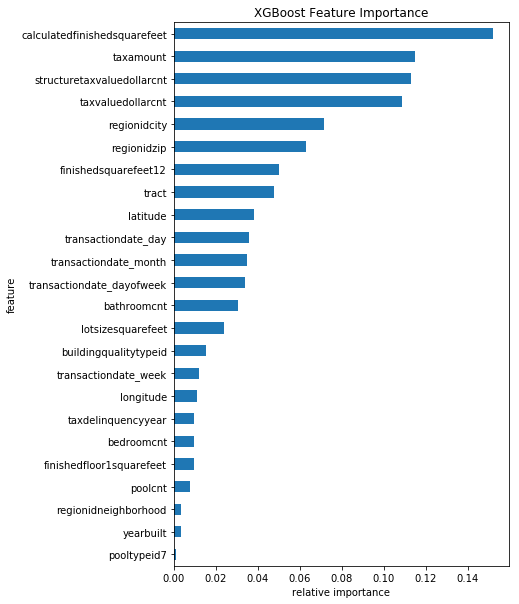

In [183]:
clf = do_train(train, clean)
importance(clf)

# MAE = 0.06565 

In [180]:
clean['area_avg'] = props[area_features].mean(axis=0)

(90275, 62) (90275,)
Building DMatrix...
Training ...
[0]	train-mae:0.492822	valid-mae:0.485397
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.447427	valid-mae:0.439998
[20]	train-mae:0.406515	valid-mae:0.399043
[30]	train-mae:0.369677	valid-mae:0.362173
[40]	train-mae:0.336524	valid-mae:0.329029
[50]	train-mae:0.30672	valid-mae:0.299253
[60]	train-mae:0.279955	valid-mae:0.272517
[70]	train-mae:0.255912	valid-mae:0.248575
[80]	train-mae:0.234348	valid-mae:0.22714
[90]	train-mae:0.215028	valid-mae:0.207968
[100]	train-mae:0.197734	valid-mae:0.19083
[110]	train-mae:0.182284	valid-mae:0.175506
[120]	train-mae:0.168484	valid-mae:0.16182
[130]	train-mae:0.156178	valid-mae:0.149618
[140]	train-mae:0.14522	valid-mae:0.138767
[150]	train-mae:0.135479	valid-mae:0.129146
[160]	train-mae:0.126834	valid-mae:0.120623
[170]	train-mae:0.119178	valid-mae:0.11309
[180]	train-mae:0.112426	va

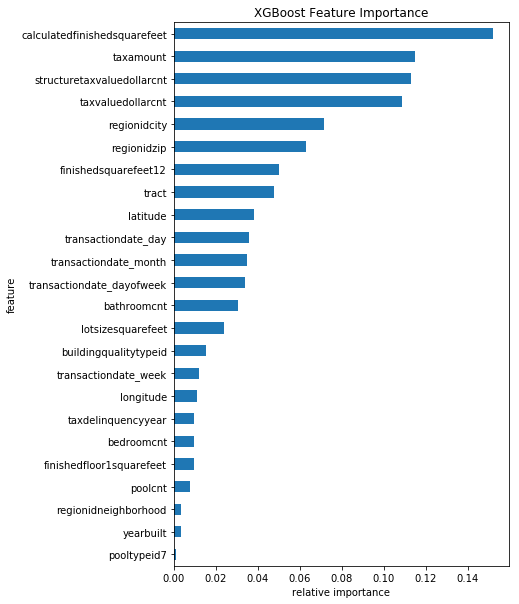

In [181]:
clf = do_train(train, clean)
importance(clf)

In [33]:
from sklearn.neighbors import KNeighborsClassifier

def fill_with_NN(df, col):
    df_train = df[~df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull()]
    df_pred = df[df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull()]
    display(df_train)
    display(df_pred)
    X = df_train.loc[:, ('longitude', 'latitude')].astype('float32')
    y = df_train[col]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X, y)
    df.loc[df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull(), (col)] = knn.predict(df_pred.loc[:, ('longitude', 'latitude')])
    display(preds)

pad('regionidcity')
pad('latitude')
pad('longitude')
fill_with_NN(clean, 'regionidcity')

describe_values(clean)
# regionidneighborhood

'regionidcity'

array([  37688.,   51617.,   12447.,  396054.,   47547.,   54311.,
         40227.,    5534.,   45888.,   33612.,   26964.,   12520.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,  118217.,   54212.,   45398.,   24174.,   30267.,
         21778.,   10723.,  118878.,   22827.,    5465.,   36502.,
         45602.,   39308.,   33836.,   24245.,   32923.,   37015.,
         24812.,   34780.,   52650.,   46314.,   38032.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   25468.,   42150.,
         40110.,   18098.,   13311.,   51239.,   34037.,   471

array([  37688.,   51617.,   12447.,  396054.,   47547.,   54311.,
         40227.,    5534.,   45888.,   33612.,   26964.,   12520.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,  118217.,   54212.,   45398.,   24174.,   30267.,
         21778.,   10723.,  118878.,   22827.,    5465.,   36502.,
         45602.,   39308.,   33836.,   24245.,   32923.,   37015.,
         24812.,   34780.,   52650.,   46314.,   38032.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   25468.,   42150.,
         40110.,   18098.,   13311.,   51239.,   34037.,   471

'latitude'

array([ 34144442.,  34140430.,  33989359., ...,  33525063.,  33634876.,
              nan])

array([ 34144442.,  34140430.,  33989359., ...,  33525063.,  33634876.,
              nan])

'longitude'

array([ -1.18654084e+08,  -1.18625364e+08,  -1.18394633e+08, ...,
        -1.18845451e+08,  -1.17801513e+08,              nan])

array([ -1.18654084e+08,  -1.18625364e+08,  -1.18394633e+08, ...,
        -1.18845451e+08,  -1.17801513e+08,              nan])

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,...,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,218440.0,261201.0,2015.0,42761.0,4054.76,NaN,NaN,NaN


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [174]:
pad('taxdelinquencyyear')

'taxdelinquencyyear'

array([ nan,  13.,  15.,  11.,  14.,   9.,  10.,   8.,  12.,   7.,   6.,
         2.,  92.,   5.,   3.,   4.,  95.,  91.,  93.,  98.,  82.,  79.,
        94.,  97.,  90.,  99.,   0.,   1.,  87.,  84.,  86.,  88.,  96.])

array([ nan,  13.,  15.,  11.,  14.,   9.,  10.,   8.,  12.,   7.,   6.,
         2.,  92.,   5.,   3.,   4.,  95.,  91.,  93.,  98.,  82.,  79.,
        94.,  97.,  90.,  99.,   0.,   1.,  87.,  84.,  86.,  88.,  96.])

In [261]:
# categorical columns
cat_cols = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid',
            'decktypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid10', 
            'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 
            'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
            'regionidzip', 'storytypeid', 'typeconstructiontypeid', 'fireplaceflag', 'assessmentyear', 
            'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'yearbuilt']

# stuff splitting the date
cat_cols.extend(['transactiondate_day', 'transactiondate_dayofweek', 'transactiondate_month', 
                 'transactiondate_week', 'transactiondate_year'])

# columns we'll drop
drop_cols = ['transactiondate', 'parcelid', 'logerror']

# continuous columns
cont_cols = set(merged.columns) - set(cat_cols) - set(drop_cols)

display(cont_cols)

{'age',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'landtaxvaluedollarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'numberofstories',
 'poolcnt',
 'poolsizesum',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'taxvaluedollarcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

In [262]:
for c in cat_cols:
    merged[c] = merged[c].astype('str')
    merged[c].fillna("")
    merged[c] = merged[c].astype('category')
for c in cont_cols: 
    merged.loc[merged[c].isnull(), c] = 0
    
#describe(merged)

In [263]:
#see if all properties have test data
subm = pd.read_csv('zillow/sample_submission.csv')

# describe(subm)

In [264]:
# see how much training data we have

# total props in submission
display(subm['ParcelId'].count())

# submission vs property data
display(subm[~subm['ParcelId'].isin(props['parcelid'])]['ParcelId'].count())

# submission vs training data
display(subm[~subm['ParcelId'].isin(train['parcelid'])]['ParcelId'].count())

2985217

0

2895067

In [265]:
X = merged.drop(drop_cols, axis=1)
X = merged.drop('logerror', axis=1)
y = merged['logerror']

In [266]:
cat_maps = [(c, LabelEncoder()) for c in cat_cols]
cont_maps = [([c], StandardScaler()) for c in cont_cols]

In [267]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(X)
len(cat_map_fit.features)

32

In [268]:
cont_mapper = DataFrameMapper(cont_maps)
cont_map_fit = cont_mapper.fit(X)
len(cont_map_fit.features)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


31

In [269]:
X_cat = cat_mapper.transform(X).astype(np.int64)
X_cont = cont_mapper.transform(X).astype(np.float32)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [270]:
X_all = np.concatenate([X_cat, X_cont], axis=1)

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.1)

In [272]:
train = xgboost.DMatrix(X_train, y_train, feature_names=cat_cols + list(cont_cols))
test = xgboost.DMatrix(X_test, y_test, feature_names=cat_cols + list(cont_cols))

In [285]:
xgb_parms = {'eta': 0.01, 'max_depth': 6, 'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': 1}

In [286]:
xgb_parms['seed'] = random.randint(0,1e9)
watchlist = [(train, 'train'), (test, 'test')]
xgbmodel = xgboost.train(xgb_parms, train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=50)

[0]	train-mae:0.492253	test-mae:0.490514
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 100 rounds.
[50]	train-mae:0.306081	test-mae:0.304423
[100]	train-mae:0.196957	test-mae:0.195456
[150]	train-mae:0.134524	test-mae:0.133135
[200]	train-mae:0.100185	test-mae:0.098941
[250]	train-mae:0.082543	test-mae:0.081343
[300]	train-mae:0.074129	test-mae:0.073052
[350]	train-mae:0.070293	test-mae:0.069268
[400]	train-mae:0.068527	test-mae:0.067582
[450]	train-mae:0.067659	test-mae:0.066816
[500]	train-mae:0.067184	test-mae:0.066461
[550]	train-mae:0.066905	test-mae:0.066294
[600]	train-mae:0.06671	test-mae:0.066228
[650]	train-mae:0.066561	test-mae:0.066205
[700]	train-mae:0.066428	test-mae:0.066199
[750]	train-mae:0.066313	test-mae:0.066208
[800]	train-mae:0.066198	test-mae:0.066253
Stopping. Best iteration:
[732]	train-mae:0.066353	test-mae:0.066193



In [287]:
xgbmodel.eval(test)

b'[0]\teval-mae:0.066267'